In [85]:
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline


In [86]:
dataset = pd.read_csv('datasets/dataset1.csv')


In [87]:
dataset.shape

(10000, 14)

In [88]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [89]:
dataset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

So as we've shown in last cell, there is no null value to retrieve.

Remove columns which are not revelant to the target value which is *Exited*

In [90]:
dataset.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [91]:
dataset.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Let's see some visualization to gain a little intuition about the data and relations between parameters.

In [92]:
plt.rcParams["figure.figsize"]=8,6

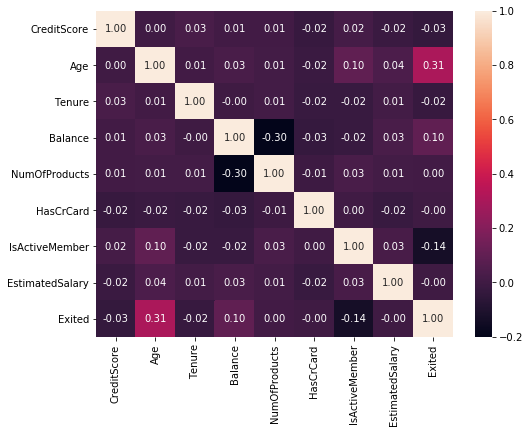

In [93]:
# sns.pairplot(data = dataset.sample(500), hue = 'Exited',)
sns.heatmap(data = dataset.sample(2000).corr(), annot=True, fmt=".2f",robust=True)

plt.show()

Text(0.5, 1.0, 'Relation between gender and exiting from the bank')

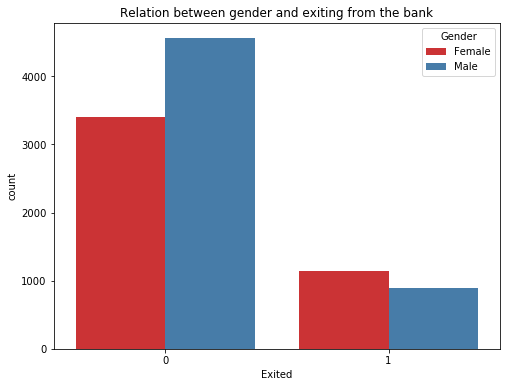

In [94]:
sns.countplot(data = dataset, x = 'Exited',hue = dataset['Gender'] , palette="Set1")
plt.title("Relation between gender and exiting from the bank")

Text(0.5, 1.0, 'Relation between having credit card and exiting from the bank')

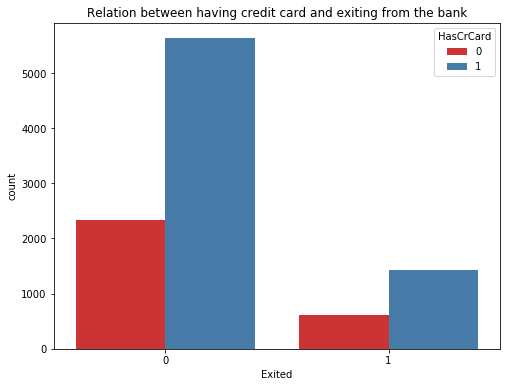

In [95]:
sns.countplot(data = dataset, x = 'Exited',hue = dataset['HasCrCard'] , palette="Set1")
plt.title("Relation between having credit card and exiting from the bank")

Text(0.5, 1.0, 'Relation between being active member and exiting from the bank')

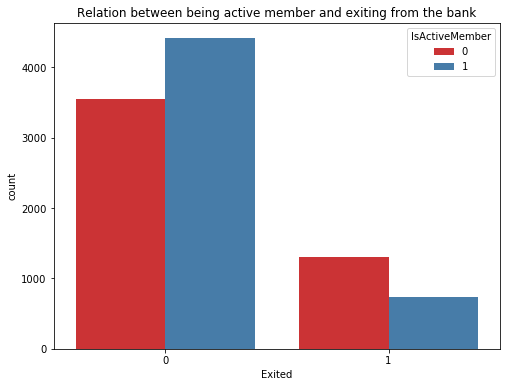

In [96]:
sns.countplot(data = dataset, x = 'Exited',hue = dataset['IsActiveMember'] , palette="Set1")
plt.title("Relation between being active member and exiting from the bank")

See the all parameters again.

In [97]:
dataset.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Few parameters are categorical and cannot be used in neural network straightly. So for each one we make a new parameter per each category.
This is done for *Geography* and *Gender*.

In [98]:
dataset = pd.get_dummies(data=dataset, drop_first=True)
print(dataset.head(5))

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            

In [99]:
size = dataset.shape[0] * 0.2
random_indices = []

while True:
    random_index = random.randint(0, len(dataset)-1)
    if random_index not in random_indices:
        random_indices.append(random_index)
    if len(random_indices) == size:
        break

df_regular = dataset.drop(labels=random_indices, axis=0).reset_index(drop=True).copy()
df_test = dataset.iloc[random_indices].reset_index(drop=True).copy()

In [100]:
print(f"Shape of regular data: {df_regular.shape}")
print(f"Shape of test data: {df_test.shape}")

Shape of regular data: (8000, 12)
Shape of test data: (2000, 12)


In [101]:
dataset = df_regular.copy()

Split data to test and train by fraction 0.2 .

In [102]:
import sklearn.model_selection as skm

In [103]:
# Train-test split
X = dataset.drop(labels=['Exited'], axis=1)
y = dataset['Exited'].values
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=100)

<h4>Feature Scaling:</h4>

To omit the difference between range of each parameters. For example having parameter *a* in range 1000-2000 nad parameter *b* in range 0-0.1 should not make the parameter *a* more important than b. So we make all the ranges the same.


In [104]:
import sklearn.preprocessing as skp
sc = skp.StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))


y_train = y_train.view(len(y_train), 1)
y_test = y_test.view(len(y_test), 1)

The following function takes an array of models and number of epochs ands show accuracy and lost for each model. It also draws a plot for each model.

In [105]:
def Print_Model_Result (models,func_names , nb_epochs , print_offset):
    features = 11
    i = 0
    for model in models:
        
        lr = 0.01
        
        print(f"Model Architecture:\n{model}")
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

        df_tracker = pd.DataFrame()
        print(f"\nTraining the model with {func_names[i]} ...")
        for epoch in range(1, nb_epochs+1):
            y_pred = model(X_train)
            loss = criterion(input=y_pred, target=y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if epoch % print_offset == 0:
                print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
            
            # Print test-accuracy after certain number of epochs
            with torch.no_grad():
                y_pred = model(X_test)
                y_pred_class = y_pred.round()
                accuracy = y_pred_class.eq(y_test).sum() / float(len(y_test))
                if epoch % print_offset == 0:
                    print(f"Accuracy on test set: {round(accuracy.item(), 4)}")
                    print(f"Loss on test set: {round(loss.item(), 4)}")

            
            df_temp = pd.DataFrame(data={
                'Epoch': epoch,
                'Loss': round(loss.item(), 4),
                'Accuracy': round(accuracy.item(), 4)
            }, index=[0])
            df_tracker = pd.concat(objs=[df_tracker, df_temp], ignore_index=True, sort=False)

        print("\nFinal result on test set:")
        print(f"\tAccuracy = {round(accuracy.item(), 4)}")
        print(f"\tLoss = {round(loss.item(), 4)}")

        plt.figure(figsize=(8, 4))
        plt.plot(df_tracker['Epoch'], df_tracker['Accuracy'], color='blue', linewidth=2, label='Accuracy')
        plt.plot(df_tracker['Epoch'], df_tracker['Loss'], color='red', linewidth=2, label='Loss')
        
        plt.title(f"Accuracy and loss over time with function {func_names[i]}", fontsize=25)
        plt.xlabel("Epoch", fontsize=16)
        plt.ylabel("Accuracy", fontsize=16)
        plt.grid()
        plt.legend(loc='best', fontsize=16)
        plt.show()

        dictionary_metrics = {
            'accuracy_testset': round(accuracy.item(), 4),
            'accuracy_Validationset': round(accuracy_test.item(), 4),
            'model': model,
            'model_state_dict': model.state_dict()
        }

        joblib.dump(value=dictionary_metrics, filename=f"weights_{func_names[i]}.pkl")
        i=i+1

Create model for functions Sigmoid, ReLU and Tanh to test which one has the least error.

In [106]:
class Network_sigmoid(nn.Module):
    
    def __init__(self, num_input_features , p = 0.0):
        super(Network_sigmoid, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 15)
        self.linear2 = nn.Linear(15, 12)
        self.linear3 = nn.Linear(12, 8)
        self.linear4 = nn.Linear(8,4)
        self.linear5 = nn.Linear(4,1)
        self.drop_layer = nn.Dropout(p=p)
    
    def forward(self, xb):
        prediction = torch.sigmoid(input=self.linear1(xb))
        prediction = self.drop_layer(input=self.linear2(prediction))
        prediction = torch.sigmoid(input=self.linear3(prediction))
        prediction = self.drop_layer(input=self.linear4(prediction))
        prediction = torch.sigmoid(input=self.linear5(prediction))
        return prediction

        #Last layer is sigmoid because we need prediction to be  in range 0,1
class Network_relu(nn.Module):
    
    def __init__(self, num_input_features , p = 0.0):
        super(Network_relu, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 15)
        self.linear2 = nn.Linear(15, 12)
        self.linear3 = nn.Linear(12, 8)
        self.linear4 = nn.Linear(8,4)
        self.linear5 = nn.Linear(4,1)
        self.drop_layer = nn.Dropout(p=p)

    
    def forward(self, xb):
        prediction = torch.relu(input=self.linear1(xb))
        prediction = self.drop_layer(input=self.linear2(prediction))
        prediction = torch.relu(input=self.linear3(prediction))
        prediction = self.drop_layer(input=self.linear4(prediction))
        prediction = torch.sigmoid(input=self.linear5(prediction))
        return prediction

class Network_tanh(nn.Module):
    
    def __init__(self, num_input_features , p = 0.0):
        super(Network_tanh, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 15)
        self.linear2 = nn.Linear(15, 12)
        self.linear3 = nn.Linear(12, 8)
        self.linear4 = nn.Linear(8,4)
        self.linear5 = nn.Linear(4,1)
        self.drop_layer = nn.Dropout(p=p)

    
    def forward(self, xb):
        prediction = torch.tanh(input=self.linear1(xb))
        prediction = self.drop_layer(input=self.linear2(prediction))
        prediction = torch.tanh(input=self.linear3(prediction))
        prediction = self.drop_layer(input=self.linear4(prediction))
        prediction = torch.sigmoid(input=self.linear5(prediction))
        return prediction

Result of fitting data with function with different number of epochs. The loss function is being computed via bachpropagation approach and algorithm Adam for optimization which use L2 regularization.

Model Architecture:
Network_sigmoid(
  (linear1): Linear(in_features=11, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=8, bias=True)
  (linear4): Linear(in_features=8, out_features=4, bias=True)
  (linear5): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

Training the model with Sigmoid function ...

Epoch 300 	 Loss: 0.416
Accuracy on test set: 0.8506
Loss on test set: 0.416

Epoch 600 	 Loss: 0.3588
Accuracy on test set: 0.87
Loss on test set: 0.3588

Epoch 900 	 Loss: 0.3479
Accuracy on test set: 0.8569
Loss on test set: 0.3479

Epoch 1200 	 Loss: 0.3494
Accuracy on test set: 0.855
Loss on test set: 0.3494

Epoch 1500 	 Loss: 0.3426
Accuracy on test set: 0.8619
Loss on test set: 0.3426

Final result on test set:
	Accuracy = 0.8619
	Loss = 0.3426


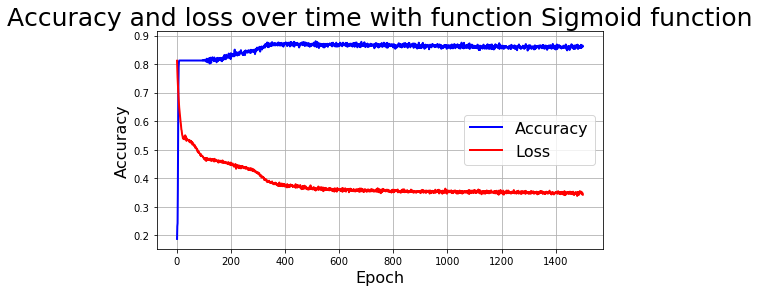

Model Architecture:
Network_relu(
  (linear1): Linear(in_features=11, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=8, bias=True)
  (linear4): Linear(in_features=8, out_features=4, bias=True)
  (linear5): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

Training the model with ReLU function ...

Epoch 300 	 Loss: 0.3505
Accuracy on test set: 0.875
Loss on test set: 0.3505

Epoch 600 	 Loss: 0.3549
Accuracy on test set: 0.8712
Loss on test set: 0.3549

Epoch 900 	 Loss: 0.3522
Accuracy on test set: 0.8712
Loss on test set: 0.3522

Epoch 1200 	 Loss: 0.3511
Accuracy on test set: 0.8675
Loss on test set: 0.3511

Epoch 1500 	 Loss: 0.3535
Accuracy on test set: 0.8725
Loss on test set: 0.3535

Final result on test set:
	Accuracy = 0.8725
	Loss = 0.3535


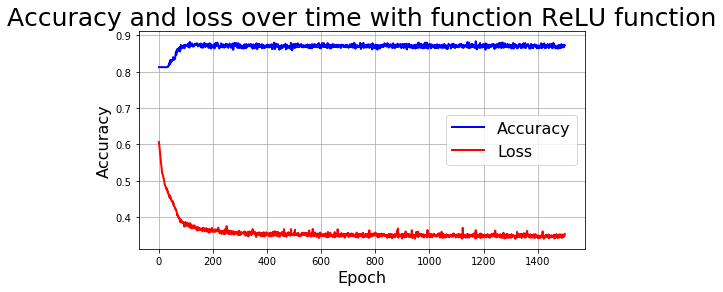

Model Architecture:
Network_tanh(
  (linear1): Linear(in_features=11, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=8, bias=True)
  (linear4): Linear(in_features=8, out_features=4, bias=True)
  (linear5): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

Training the model with Tanh function ...

Epoch 300 	 Loss: 0.3686
Accuracy on test set: 0.8731
Loss on test set: 0.3686

Epoch 600 	 Loss: 0.3537
Accuracy on test set: 0.8744
Loss on test set: 0.3537

Epoch 900 	 Loss: 0.346
Accuracy on test set: 0.87
Loss on test set: 0.346

Epoch 1200 	 Loss: 0.3405
Accuracy on test set: 0.8744
Loss on test set: 0.3405

Epoch 1500 	 Loss: 0.3409
Accuracy on test set: 0.875
Loss on test set: 0.3409

Final result on test set:
	Accuracy = 0.875
	Loss = 0.3409


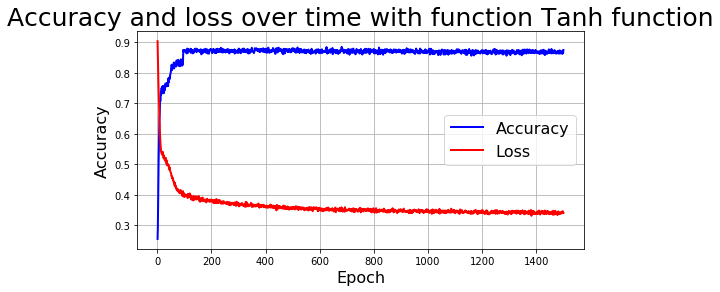

In [107]:
features = 11
model_relu = Network_relu(num_input_features=features , p = 0.5)
model_sigmoid = Network_sigmoid(num_input_features= features , p = 0.5)
model_tanh = Network_tanh(num_input_features= features , p = 0.5)

models= [ model_sigmoid, model_relu ,model_tanh]
func_names = ['Sigmoid function' ,'ReLU function','Tanh function']
i = 0

Print_Model_Result(models , func_names,1500,300)


As the demographics and numeric results shows,the best accuracy and the least loss is occured with algorithm ReLU and Tanh(ReLU has least loss).
So let's create a new model using both functions with different layers and see the difference while changing dropout sizes and with larger epochs.

In [108]:
class Network_Drop(nn.Module):
    
    def __init__(self, num_input_features , p = 0.0):
        super(Network_Drop, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 16)
        self.linear2 = nn.Linear(16, 20)
        self.linear3 = nn.Linear(20, 15)
        self.linear4 = nn.Linear(15,12)
        self.linear5 = nn.Linear(12, 10)
        self.linear6 = nn.Linear(10,6)
        self.linear7 = nn.Linear(6,4)
        self.linear8 = nn.Linear(4,1)
        self.drop_layer = nn.Dropout(p=p)

    
    def forward(self, xb):
        prediction = torch.tanh(input=self.linear1(xb))
        prediction = self.drop_layer(input=self.linear2(prediction))
        prediction = torch.relu(input = self.linear3(prediction))
        prediction = self.drop_layer(input=self.linear4(prediction))
        prediction = torch.tanh(input = self.linear5(prediction))
        prediction = self.drop_layer(input=self.linear6(prediction))
        prediction = torch.relu(input = self.linear7(prediction))
        prediction = torch.sigmoid(input=self.linear8(prediction))
        return prediction

Model Architecture:
Network_Drop(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=15, bias=True)
  (linear4): Linear(in_features=15, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=6, bias=True)
  (linear7): Linear(in_features=6, out_features=4, bias=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.0, inplace=False)
)

Training the model with p = 0.0 ...

Epoch 1000 	 Loss: 0.2326
Accuracy on test set: 0.8644
Loss on test set: 0.2326

Epoch 2000 	 Loss: 0.2105
Accuracy on test set: 0.8506
Loss on test set: 0.2105

Epoch 3000 	 Loss: 0.2001
Accuracy on test set: 0.8475
Loss on test set: 0.2001

Final result on test set:
	Accuracy = 0.8475
	Loss = 0.2001


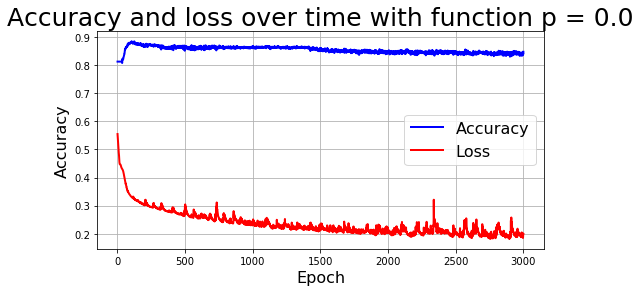

Model Architecture:
Network_Drop(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=15, bias=True)
  (linear4): Linear(in_features=15, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=6, bias=True)
  (linear7): Linear(in_features=6, out_features=4, bias=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.3, inplace=False)
)

Training the model with p = 0.3 ...

Epoch 1000 	 Loss: 0.3028
Accuracy on test set: 0.8719
Loss on test set: 0.3028

Epoch 2000 	 Loss: 0.2974
Accuracy on test set: 0.8637
Loss on test set: 0.2974

Epoch 3000 	 Loss: 0.288
Accuracy on test set: 0.8575
Loss on test set: 0.288

Final result on test set:
	Accuracy = 0.8575
	Loss = 0.288


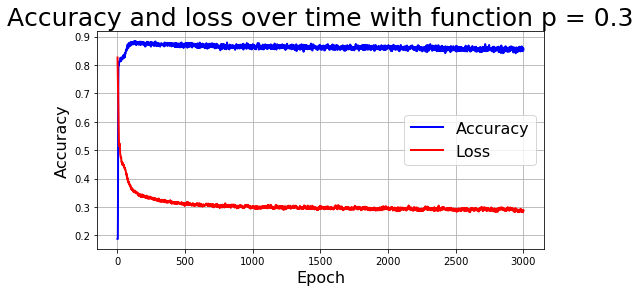

Model Architecture:
Network_Drop(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=15, bias=True)
  (linear4): Linear(in_features=15, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=6, bias=True)
  (linear7): Linear(in_features=6, out_features=4, bias=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.8, inplace=False)
)

Training the model with p = 0.5 ...

Epoch 1000 	 Loss: 0.3945
Accuracy on test set: 0.8494
Loss on test set: 0.3945

Epoch 2000 	 Loss: 0.3911
Accuracy on test set: 0.855
Loss on test set: 0.3911

Epoch 3000 	 Loss: 0.3888
Accuracy on test set: 0.8481
Loss on test set: 0.3888

Final result on test set:
	Accuracy = 0.8481
	Loss = 0.3888


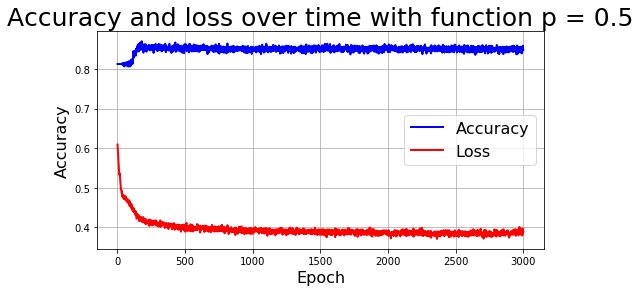

Model Architecture:
Network_Drop(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=15, bias=True)
  (linear4): Linear(in_features=15, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=6, bias=True)
  (linear7): Linear(in_features=6, out_features=4, bias=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

Training the model with p = 0.8 ...

Epoch 1000 	 Loss: 0.316
Accuracy on test set: 0.8631
Loss on test set: 0.316

Epoch 2000 	 Loss: 0.3038
Accuracy on test set: 0.8587
Loss on test set: 0.3038

Epoch 3000 	 Loss: 0.3027
Accuracy on test set: 0.8644
Loss on test set: 0.3027

Final result on test set:
	Accuracy = 0.8644
	Loss = 0.3027


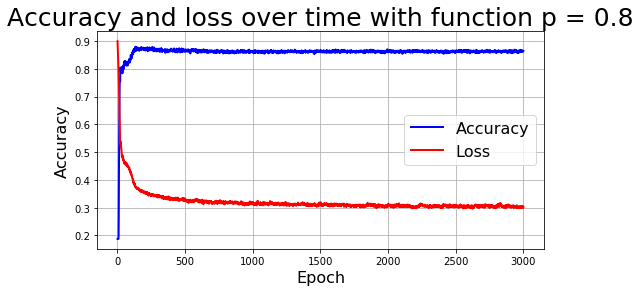

In [109]:
model_drop1 = Network_Drop(num_input_features= features , p = 0.0)
model_drop2 = Network_Drop(num_input_features= features , p = 0.3)
model_drop4 = Network_Drop(num_input_features= features , p = 0.5)
model_drop3 = Network_Drop(num_input_features= features , p = 0.8)

drop_models= [model_drop1 , model_drop2 , model_drop3 , model_drop4]
func_names = ['p = 0.0' ,'p = 0.3','p = 0.5','p = 0.8']

Print_Model_Result(drop_models , func_names , 3000 , 1000)


So by looking at accuracies, we have the best results at p = 0.0 and less than 20 epochs

Now trying batch normalization layers between some layers:


In [110]:
class Network_Batch(nn.Module):
    
    def __init__(self, num_input_features , p = 0.0):
        super(Network_Batch, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 16)
        self.batch1 = nn.BatchNorm1d(16 )

        self.linear2 = nn.Linear(16, 12)
        self.linear3 = nn.Linear(12, 10)
        self.batch2 = nn.BatchNorm1d(10 )

        self.linear4 = nn.Linear(10,12)
        self.linear5 = nn.Linear(12, 10)
        self.batch3  = nn.BatchNorm1d(10)

        self.linear6 = nn.Linear(10,8)
        self.linear7 = nn.Linear(8,4)
        self.batch4  = nn.BatchNorm1d(4)

        self.linear8 = nn.Linear(4,1)
        self.drop_layer = nn.Dropout(p=p)

    
    def forward(self, xb):
        prediction = torch.relu(input=self.linear1(xb))
        prediction = self.batch1(prediction)
        prediction = self.drop_layer(input=self.linear2(prediction))
        prediction = torch.relu(input = self.linear3(prediction))
        prediction = self.batch2(prediction)
        prediction = self.drop_layer(input=self.linear4(prediction))
        prediction = torch.tanh(input = self.linear5(prediction))
        prediction = self.batch3(prediction)
        prediction = self.drop_layer(input=self.linear6(prediction))
        prediction = torch.relu(input = self.linear7(prediction))
        prediction = self.batch4(input = prediction)
        prediction = torch.sigmoid(input=self.linear8(prediction))
        return prediction

By looking at demograohic series 1, with ecpoch numbers less than 100 we have better result so I lessend the epoch numbers range.

Model Architecture:
Network_Batch(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (batch1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=16, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=10, bias=True)
  (batch2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (batch3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=10, out_features=8, bias=True)
  (linear7): Linear(in_features=8, out_features=4, bias=True)
  (batch4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.0, inplace=False)
)

Training the model with batch normalizatio

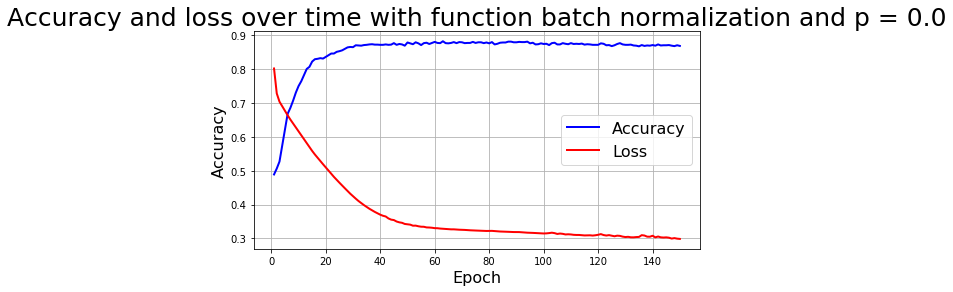

Model Architecture:
Network_Batch(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (batch1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=16, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=10, bias=True)
  (batch2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (batch3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=10, out_features=8, bias=True)
  (linear7): Linear(in_features=8, out_features=4, bias=True)
  (batch4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.3, inplace=False)
)

Training the model with batch normalizatio

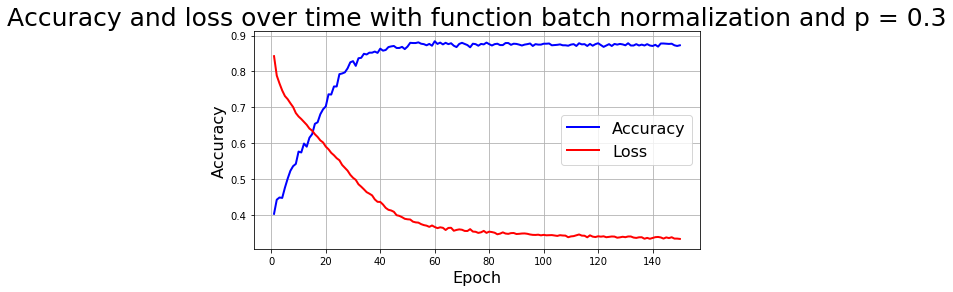

Model Architecture:
Network_Batch(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (batch1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=16, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=10, bias=True)
  (batch2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (batch3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=10, out_features=8, bias=True)
  (linear7): Linear(in_features=8, out_features=4, bias=True)
  (batch4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
)

Training the model with batch normalizatio

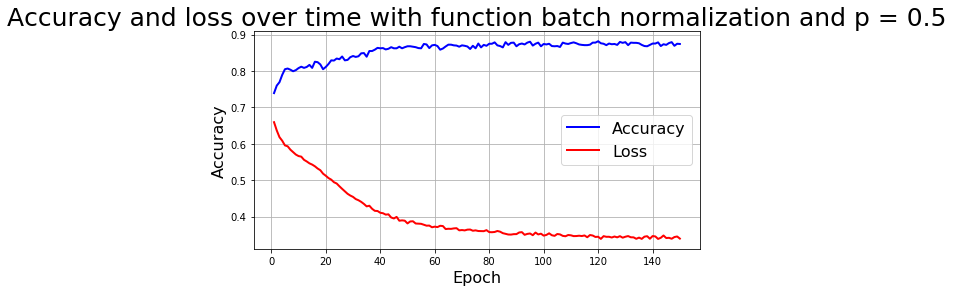

Model Architecture:
Network_Batch(
  (linear1): Linear(in_features=11, out_features=16, bias=True)
  (batch1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=16, out_features=12, bias=True)
  (linear3): Linear(in_features=12, out_features=10, bias=True)
  (batch2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=10, bias=True)
  (batch3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=10, out_features=8, bias=True)
  (linear7): Linear(in_features=8, out_features=4, bias=True)
  (batch4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear8): Linear(in_features=4, out_features=1, bias=True)
  (drop_layer): Dropout(p=0.7, inplace=False)
)

Training the model with batch normalizatio

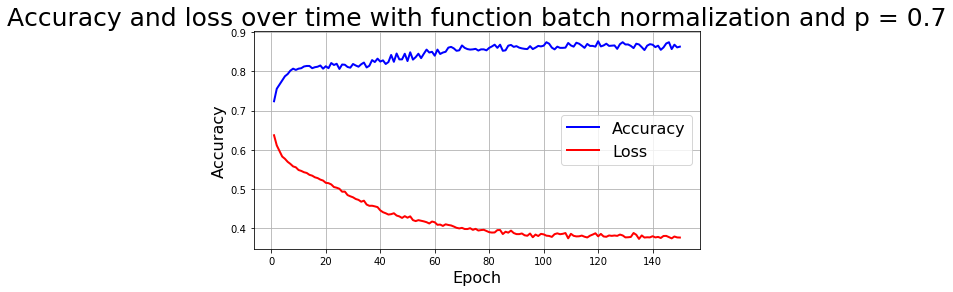

In [111]:
model_batch1 = Network_Batch(num_input_features= features , p = 0.0)
model_batch2 = Network_Batch(num_input_features= features , p = 0.3)
model_batch3 = Network_Batch(num_input_features= features , p = 0.5)
model_batch4 = Network_Batch(num_input_features= features , p = 0.7)


batch_models = [model_batch1,model_batch2,model_batch3,model_batch4]
func_names = ['batch normalization and p = 0.0','batch normalization and p = 0.3','batch normalization and p = 0.5','batch normalization and p = 0.7']

Print_Model_Result(batch_models , func_names , 150 , 30)


In conclusion, by looking at all acuracies and results, last 

In [112]:

best_models = [model_relu,model_tanh,model_drop1, model_batch1 , model_batch2]
best_names = ['model_relu','model_tanh','model_drop1','model_batch1','model_batch2']

In [113]:
X_test = df_test.drop(labels=['Exited'], axis=1)
y_test = df_test['Exited'].values

X_test = sc.transform(X_test)
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
y_test = y_test.view(len(y_test), 1)
i = 0
for best_model in best_models:
    with torch.no_grad():
        y_test_pred = best_model(X_test)
        y_test_pred_class = y_test_pred.round()
        accuracy_test = y_test_pred_class.eq(y_test).sum() / float(len(y_test))
        print(f"\nFinal accuracy with {best_names[i]} on test set: {round(accuracy_test.item(), 4)}")
        i = i+1


Final accuracy with model_relu on test set: 0.855

Final accuracy with model_tanh on test set: 0.85

Final accuracy with model_drop1 on test set: 0.8235

Final accuracy with model_batch1 on test set: 0.8465

Final accuracy with model_batch2 on test set: 0.8665


So best model is model_relu without those batch and dropout layers but the difference is very slight and it can be disregarded.